<a href="https://colab.research.google.com/github/whyamistudyingcs/FYP_attack/blob/main/xlnet_ag_news_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The TextAttack ecosystem: search, transformations, and constraints

#installation


In [ ]:
!pip3 install textattack[tensorflow]
!pip3 install tensorflow==2.14
!pip3 install datasets
!pip3 install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.8/436.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.2/387.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 99.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 97.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboa

# Training

In [ ]:
import transformers
from datasets import load_dataset, load_dataset_builder, DatasetDict
import evaluate
import torch
from torch.utils.data import random_split

In [ ]:
train_dataset = load_dataset("ag_news", split="train")
test_dataset = load_dataset("ag_news", split="test")

def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:250]),
        'label': example['label']
    }

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
from transformers import XLNetTokenizer
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
MAX_LENGTH=250

tokenized_train_dataset = train_dataset.map(
    lambda example: tokenizer(example['text'], padding='max_length', truncation=True,max_length=MAX_LENGTH),
    batched=True,
    batch_size=32,
)

tokenized_train_dataset = tokenized_train_dataset.remove_columns(["text"])
tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_train_dataset.set_format("torch")

val_size = 7600
train_size = len(tokenized_train_dataset) - val_size
tokenized_train_dataset, tokenized_eval_dataset = random_split(tokenized_train_dataset, [train_size, val_size])

tokenized_test_dataset = test_dataset.map(
    lambda example: tokenizer(example['text'], padding='max_length', truncation=True,max_length=MAX_LENGTH),
    batched=True,
    batch_size=32,
)

tokenized_test_dataset = tokenized_test_dataset.remove_columns(["text"])
tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")
tokenized_test_dataset.set_format("torch")

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(tokenized_train_dataset, shuffle=True, batch_size=32)
eval_dataloader = DataLoader(tokenized_eval_dataset, batch_size=32)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=32)

In [ ]:
from transformers import XLNetForSequenceClassification

from torch.optim import AdamW

model = XLNetForSequenceClassification.from_pretrained("ken1in/xlnet-ag_news")
optimizer = AdamW(model.parameters(), lr=2e-5)

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

# Training

In [ ]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def saveModel(epoch):
  model.save_pretrained("drive/MyDrive/ken1in/xlnet-ag_news")
  model.push_to_hub("xlnet-ag_news")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import pickle
# save dictionary to person_data.pkl file
def saveStats(training_stats):
  with open('/content/drive/MyDrive/training_stats.pkl', 'wb') as fp:
    pickle.dump(training_stats, fp)
    print('dictionary saved successfully to file')

In [ ]:
def loadStats():
  with open('/content/drive/MyDrive/training_stats.pkl', 'rb') as fp:
    training_stats = pickle.load(fp)
    train_loss_record = training_stats[-1]["Train lost Hist"]
    val_loss_record = training_stats[-1]["Val lost Hist"]
    current_epoch = training_stats[-1]["epoch"]

In [ ]:
loadStats()

In [ ]:
train_loss_record  = []
val_loss_record = []
training_stats = []
current_epoch = 0

In [ ]:
from tqdm.auto import tqdm
import evaluate

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    # Train
    model.train()
    total_train_loss = 0
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss_record.append(loss.item())
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Eval
    model.eval()
    metric = evaluate.load("accuracy")
    val_loss_record = []
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
          outputs = model(**batch)
        loss = outputs.loss
        val_loss_record.append(loss.item())
        total_eval_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    accuracy = metric.compute()

    avg_val_loss = total_eval_loss / len(eval_dataloader)

    training_stats.append({
            'epoch': 1,
            "Train lost Hist": train_loss_record,
            "Val lost Hist": val_loss_record,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': accuracy["accuracy"],
        })

saveStats(training_stats)
model.push_to_hub("xlnet-ag_news")

  0%|          | 0/10539 [00:00<?, ?it/s]

dictionary saved successfully to file


model.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ken1in/xlnet-ag_news/commit/e0545d9e5f9243dfe40682fc1f6b7d0321747a60', commit_message='Upload XLNetForSequenceClassification', commit_description='', oid='e0545d9e5f9243dfe40682fc1f6b7d0321747a60', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.save_model("test")

AttributeError: ignored

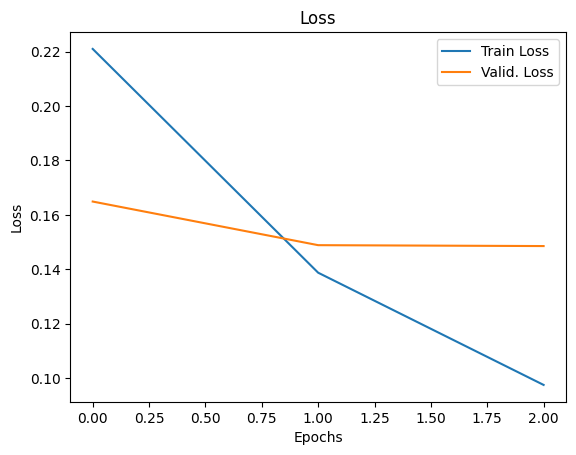

In [ ]:
import matplotlib.pyplot as plt

train_loss_values = [d['Training Loss'] for d in training_stats]
val_loss_values = [d['Valid. Loss'] for d in training_stats]
plt.plot(train_loss_values,label='Train Loss')
plt.plot(val_loss_values,label='Valid. Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# attack

In [ ]:
# Import the model
import transformers
from textattack.models.wrappers import HuggingFaceModelWrapper

model_wrapper = HuggingFaceModelWrapper(model, tokenizer)


# Import the dataset
from textattack.datasets import HuggingFaceDataset

dataset = HuggingFaceDataset("ag_news", None, "test")

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
textattack: Loading datasets dataset ag_news, split test.


### Creating the attack
Let's keep it simple: let's use a greedy search method, and let's not use any constraints for now.

In [ ]:
!pip install sentence_transformers
!pip install torchfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=c15378d2a772ce7ae38e77b74b4c0648f3862d284e1619eea99bcecb44fd9ff0
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
  Preparing metadata (setup.py) ... done
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5694 sha256=416e69e96a68609dbe7d6cc50d95d414b500ba82b50e2c54052e3f5e13b93eba
  Stored in directory: /root/.cache/pip/wheels/c7/e9/87/1c51daf8e468d5c14931f8ac3344880f903ba96b063675cac2
Successfully built torchfile


In [ ]:
from textattack.attack_recipes import PWWSRen2019, A2TYoo2021, BERTAttackLi2020, FasterGeneticAlgorithmJia2019
from textattack import Attacker

attack = PWWSRen2019.build(model_wrapper)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
# customized attack
from textattack.goal_functions import UntargetedClassification
from textattack.constraints.overlap import MaxWordsPerturbed
from textattack.constraints.pre_transformation import (
    RepeatModification,
    StopwordModification,
)
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.search_methods import GreedyWordSwapWIR
from textattack.transformations import WordSwapMaskedLM
from textattack import Attack

transformation = WordSwapMaskedLM(method="bert-attack", max_candidates=32)
constraints = [RepeatModification(), StopwordModification()]
constraints.append(MaxWordsPerturbed(max_percent=0.4))
use_constraint = UniversalSentenceEncoder(
    threshold=0.3,
    metric="cosine",
    compare_against_original=True,
    window_size=None,
)

constraints.append(use_constraint)
goal_function = UntargetedClassification(model_wrapper)
search_method = GreedyWordSwapWIR()

attack = Attack(goal_function, constraints, transformation, search_method)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
# customized attack
from textattack.goal_functions import UntargetedClassification
from textattack.constraints.overlap import MaxWordsPerturbed
from textattack.constraints.grammaticality import PartOfSpeech
from textattack.constraints.pre_transformation import (
    InputColumnModification,
    RepeatModification,
    StopwordModification,
    MaxModificationRate,
)
from textattack.constraints.semantics import WordEmbeddingDistance
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder, BERT
from textattack.search_methods import GreedyWordSwapWIR
from textattack.transformations import WordSwapEmbedding, WordSwapMaskedLM
from textattack import Attack

# transformation = WordSwapMaskedLM(method="bert-attack", max_candidates=24)

constraints = [RepeatModification(), StopwordModification()]
input_column_modification = InputColumnModification(
  ["premise", "hypothesis"], {"premise"}
)

constraints.append(input_column_modification)
constraints.append(PartOfSpeech(allow_verb_noun_swap=False))
constraints.append(MaxModificationRate(max_rate=0.2, min_threshold=4))

sent_encoder = BERT(
    model_name="stsb-distilbert-base", threshold=0.8, metric="cosine"
)
constraints.append(sent_encoder)


'''
# without MLM
transformation = WordSwapEmbedding(max_candidates=30)
constraints.append(WordEmbeddingDistance(min_cos_sim=0.8))

'''



transformation = transformation = WordSwapMaskedLM(
    method="bae", max_candidates=30, min_confidence=0.0, batch_size=16
)


'''
use_constraint = UniversalSentenceEncoder(
    threshold=0.2,
    metric="cosine",
    compare_against_original=True,
    window_size=None,
)
'''

max_len =  250
goal_function = UntargetedClassification(model_wrapper, model_batch_size=16)
search_method = GreedyWordSwapWIR(wir_method="gradient")

attack = Attack(goal_function, constraints, transformation, search_method)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.xlnet.modeling_xlnet.XLNetForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


TypeError: ignored

Let's print our attack to see all the parameters:

In [ ]:
print(attack)


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  48
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.2
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.2
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
)


In [ ]:
print(dataset)

### Using the attack

Let's use our attack to successfully attack 10 samples.

In [ ]:
from tqdm import tqdm  # tqdm provides us a nice progress bar.
from textattack.loggers import CSVLogger  # tracks a dataframe for us.
from textattack.attack_results import SuccessfulAttackResult
from textattack import Attacker
from textattack import AttackArgs
from textattack.datasets import Dataset

attack_args = AttackArgs(num_examples=32)

attacker = Attacker(attack, dataset, attack_args)

attack_results = attacker.attack_dataset()


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  unk
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bert-attack
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  32
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): MaxWordsPerturbed(
        (max_percent):  0.4
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.3
        (window_size):  inf
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 







  0%|          | 0/32 [00:00<?, ?it/s]



  3%|▎         | 1/32 [00:14<07:15, 14.04s/it]



[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:   3%|▎         | 1/32 [00:14<07:16, 14.07s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[Business (99%)]] --> [[World (52%)]]

[[Fears]] for T N [[pension]] after talks Unions representing workers at [[Turner]]   [[Newall]] say they are '[[disappointed']] after talks with stricken parent firm Federal Mogul.

[[march]] for T N [[medicare]] after talks Unions representing workers at [[international]]   [[newmills]] say they are '[[disappointed-]] after talks with stricken parent firm Federal Mogul.




KeyboardInterrupt: ignored

### Visualizing attack results

We are logging `AttackResult` objects using a `CSVLogger`. This logger stores all attack results in a dataframe, which we can easily access and display. Since we set `color_method` to `'html'`, the attack results will display their differences, in color, in HTML. Using `IPython` utilities and `pandas`

In [ ]:
import pandas as pd

pd.options.display.max_colwidth = (
    480  # increase colum width so we can actually read the examples
)

logger = CSVLogger(color_method="html")

for result in attack_results:
    if isinstance(result, SuccessfulAttackResult):
        logger.log_attack_result(result)

from IPython.core.display import display, HTML

results = pd.DataFrame.from_records(logger.row_list)
display(HTML(results[["original_text", "perturbed_text"]].to_html(escape=False)))

textattack: Logging to CSV at path results.csv


,original_text,perturbed_text
0,Fears for T N pension after talks Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.,Fears for thyroxin N pension after spill Unions stage workers at Turner Newall say they are 'disappointed' after talks with stricken parent steadfastly Federal king.
1,"Ky. Company Wins Grant to Study Peptides (AP) AP - A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.","Ky. party advance concede to consider peptide (AP) AP - A company institute by a chemistry researcher at the university of Louisville won a accord to modernise a method of producing skilful peptides, which are dead irons of amino dose, the building barricade of proteins."
2,"Prediction Unit Helps Forecast Wildfires (AP) AP - It's barely dawn when Mike Fitzpatrick starts his shift with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar.","anticipation Unit Helps bode wildfire (AP) AP - It's barely dawn when Mike Fitzpatrick starts his dislodge with a blur of colorful maps, figures and endless charts, but already he knows what the day will bring. Lightning will strike in places he expects. Winds will pick up, moist places will dry and flames will roar."
3,"Calif. Aims to Limit Farm-Related Smog (AP) AP - Southern California's smog-fighting agency went after emissions of the bovine variety Friday, adopting the nation's first rules to reduce air pollution from dairy cow manure.","khalif. train to set Farm-Related smog (AP) AP - southern California's smog-fighting agency expire after emissions of the bovine mixture Friday, adopting the nation's low rule to reduce publicise pollution from dairy cow manure."
4,"Card fraud unit nets 36,000 cards In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estimates it saved 65m.","Card fraud unit profit 36,000 cards In its first two years, the UK's dedicated card fraud unit, has recovered 36,000 stolen cards and 171 arrests - and estimates it saved 65m."
5,"Group to Propose New High-Speed Wireless Format LOS ANGELES (Reuters) - A group of technology companies including Texas Instruments Inc. <TXN.N>, STMicroelectronics <STM.PA> and Broadcom Corp. <BRCM.O>, on Thursday said they will propose a new wireless networking standard up to 10 times the speed of the current generation.","Group to Propose New High-Speed Wireless arrange LOS ANGELES (Reuters) - axerophthol group of technology companies admit Texas Instruments Inc. <TXN.N>, STMicroelectronics <STM.dad> and Broadcom Corp. <BRCM.O>, on Thursday allege they will nominate a new wireless networking stock up to 10 times the speed of the current generation."
6,"Socialites unite dolphin groups Dolphin groups, or ""pods"", rely on socialites to keep them from collapsing, scientists claim.","Socialites unite dolphin groups dolphin groups, or ""pods"", trust on socialites to hold them from collapsing, scientists claim."
7,"Rocking the Cradle of Life When did life begin? One evidential clue stems from the fossil records in Western Australia, although whether these layered sediments are biological or chemical has spawned a spirited debate. Oxford researcher, Nicola McLoughlin, describes some of the issues in contention.","sway the rocker of biography When did biography begin? One evidential clue fore from the fogy memorialise in Western Australia, although whether these layered sediments are biological or chemical has spawned a spirited debate. Oxford researcher, Nicola McLoughlin, name some of the proceeds in contention."
8,"Storage, servers bruise HP earnings update Earnings per share rise compared with a year ago, but comp

### Conclusion
We can examine these examples for a good idea of how many words had to be changed to "banana" to change the prediction score from the correct class to another class. The examples without perturbed words were originally misclassified, so they were skipped by the attack. Looks like some examples needed only a couple "banana"s, while others needed up to 17 "banana" substitutions to change the class score. Wow! 🍌

### Appendices: Attacking Custom Samples

We can also attack custom data samples, like these ones I just made up!

In [ ]:


custom_dataset = [
    ("And while Fushimi gives a kind speech at the end, her unyielding response to Saori’s desperate questions also doesn’t look much better in hindsight after we’ve gotten to know her better.", 1)
]

attack_args = AttackArgs(num_examples=4)

dataset = Dataset(custom_dataset)

attacker = Attacker(attack, dataset, attack_args)

results_iterable = attacker.attack_dataset()

logger = CSVLogger(color_method="html")

for result in results_iterable:
    logger.log_attack_result(result)

from IPython.core.display import display, HTML

display(HTML(logger.df[["original_text", "perturbed_text"]].to_html(escape=False)))

textattack: Attempting to attack 4 samples when only 1 are available.


Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  weighted-saliency
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapWordNet
  (constraints): 
    (0): RepeatModification
    (1): StopwordModification
  (is_black_box):  True
) 





  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:13<00:39, 13.25s/it]

[Succeeded / Failed / Skipped / Total] 1 / 0 / 0 / 1:  25%|██▌       | 1/4 [00:13<00:39, 13.29s/it]

--------------------------------------------- Result 1 ---------------------------------------------
[[1 (62%)]] --> [[0 (40%)]]

And while Fushimi gives a kind speech at the end, her unyielding response to Saori’s desperate [[questions]] also doesn’t look much better in hindsight after we’ve gotten to know her better.

And while Fushimi gives a kind speech at the end, her unyielding response to Saori’s desperate [[interrogation]] also doesn’t look much better in hindsight after we’ve gotten to know her better.



+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 1      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 2.94%  |
| Average num. words per input: | 34.0   |
| Avg n


textattack: Logging to CSV at path results.csv


,original_text,perturbed_text
0,"And while Fushimi gives a kind speech at the end, her unyielding response to Saori’s desperate questions also doesn’t look much better in hindsight after we’ve gotten to know her better.","And while Fushimi gives a kind speech at the end, her unyielding response to Saori’s desperate interrogation also doesn’t look much better in hindsight after we’ve gotten to know her better."


In [ ]:
from tqdm import tqdm  # tqdm provides us a nice progress bar.
from textattack.loggers import CSVLogger  # tracks a dataframe for us.
from textattack.attack_results import SuccessfulAttackResult
from textattack import Attacker
from textattack import AttackArgs
from textattack.datasets import Dataset


from textattack.attack_recipes import PWWSRen2019, A2TYoo2021, BERTAttackLi2020, FasterGeneticAlgorithmJia2019
from textattack import Attacker

attack = A2TYoo2021.build(model_wrapper)

attack_args = AttackArgs(num_examples=32)

attacker = Attacker(attack, dataset, attack_args)

attack_results = attacker.attack_dataset()

import pandas as pd

pd.options.display.max_colwidth = (
    480  # increase colum width so we can actually read the examples
)

logger = CSVLogger(color_method="html")

for result in attack_results:
    if isinstance(result, SuccessfulAttackResult):
        logger.log_attack_result(result)

from IPython.core.display import display, HTML

results = pd.DataFrame.from_records(logger.row_list)
display(HTML(results[["original_text", "perturbed_text"]].to_html(escape=False)))


ModuleNotFoundError: ignored